In [1]:
import numpy as np
import graph_tool.all as gt
from rich import print
import random
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
from simulation_with_time_window import simulate_SIS, make_node_feature_df

Hello from cn-final-project!

100%|██████████| 1233/1233 [07:47<00:00,  2.64it/s, Infected fraction=0.124]


Text(0.5, 1.0, 'Temporal SIS epidemic simulation (undirected)')

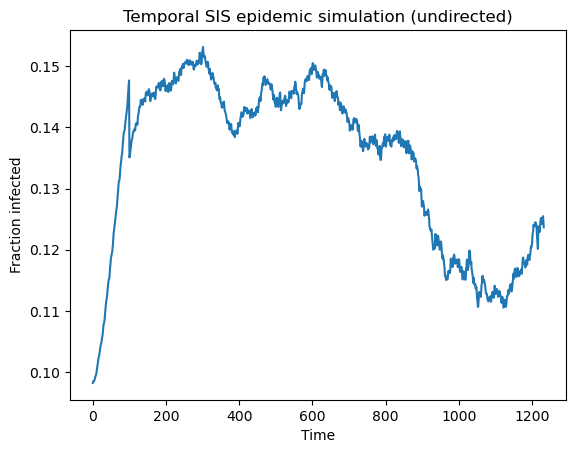

In [ ]:
# random.seed(42)
print("Hello from cn-final-project!")
g = gt.collection.ns["escorts"]

sim, g = simulate_SIS(g, max_steps=150, start=1000)

plt.plot(sim)
plt.xlabel("Time")
plt.ylabel("Fraction infected")
plt.title("Temporal SIS epidemic simulation (undirected)")
# plt.savefig("plots/temporal_sis_simulation_with_time_window.png")
# plt.show()

In [23]:
df = make_node_feature_df(g)
print(df)

Computing centrality metrics...

Computed degree

Computed leverage

Computed betweenness

node  degree  leverage  betweenness  cumulative_infected
0          0      49  0.709559     0.002755                    2
1          1      24 -0.244821     0.001299                    6
2          2      39  0.407448     0.001819                    5
3          3       1 -0.920000     0.000000                    0
4          4       1 -0.960000     0.000000                    0
...      ...     ...       ...          ...                  ...
16725  16725       1 -0.333333     0.000000                    0
16726  16726       1  0.000000     0.000000                    0
16727  16727       1  0.000000     0.000000                    0
16728  16728       1  0.000000     0.000000                    0
16729  16729       1  0.000000     0.000000                    0

[16730 rows x 5 columns]

<Axes: xlabel='betweenness', ylabel='cumulative_infected'>

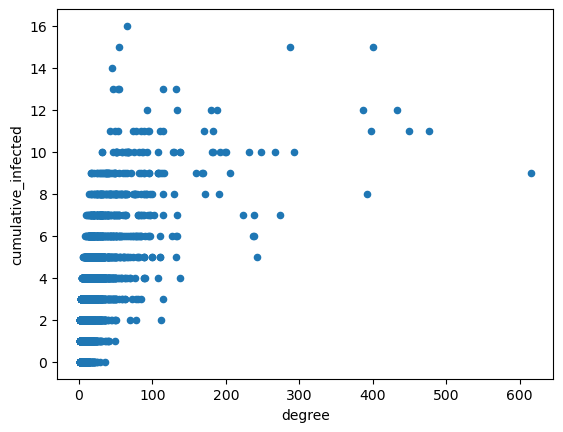

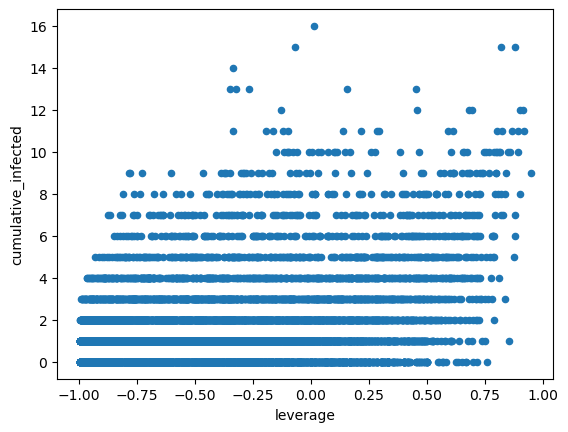

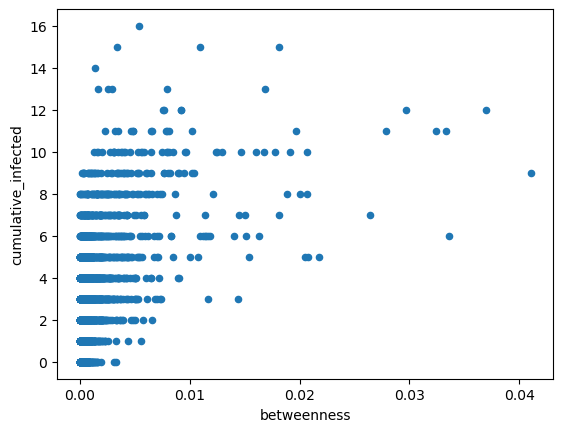

In [24]:
df.plot.scatter(x="degree", y="cumulative_infected")
df.plot.scatter(x="leverage", y="cumulative_infected")
df.plot.scatter(x="betweenness", y="cumulative_infected")


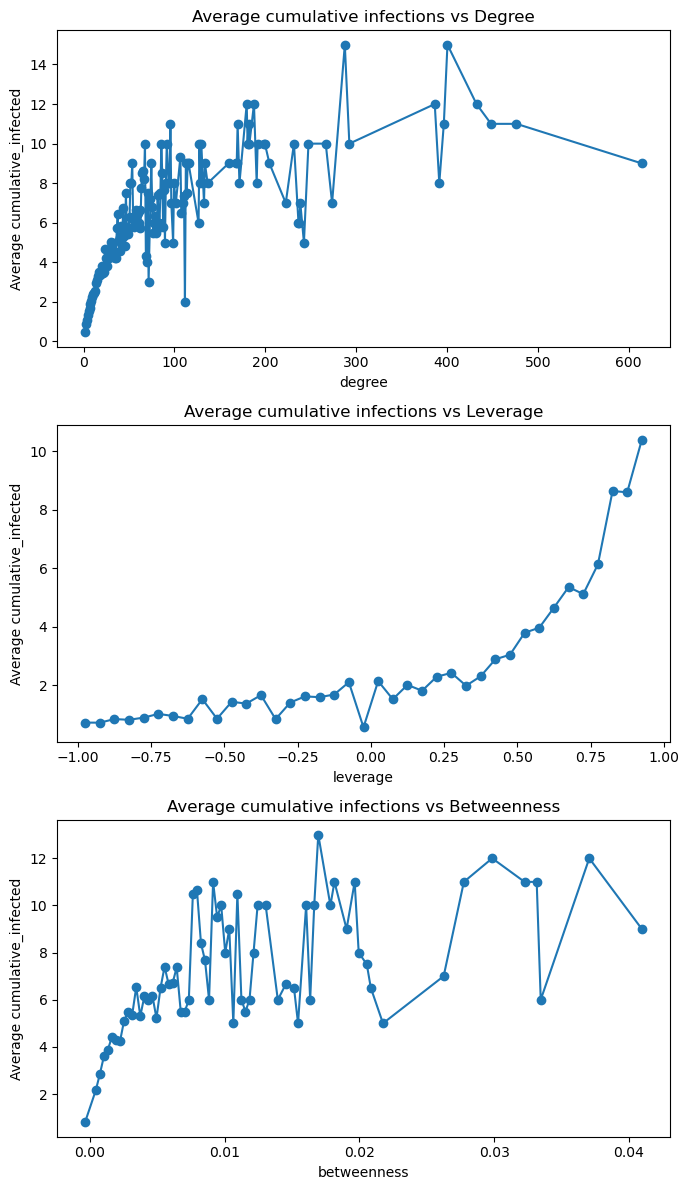

In [ ]:
def binned_mean_plot(df, x_col, y_col="cumulative_infected", bin_size=None, bins=None, ax=None, title=None):
    """
    Used to plot cumulative_infected vs node property for 1 run

    Plot the mean of y_col within bins of x_col.
    - If bins is given, it overrides bin_size.
    - If neither is given and x_col is integer-like, groups by exact value.
    - Returns the aggregated dataframe with columns: ['bin_left','bin_right','center','mean','count'].
    """
    data = df[[x_col, y_col]].dropna()

    if bins is None and bin_size is None:
        # If no binning specified, group by exact x (useful for integer degrees)
        grp = data.groupby(x_col)[y_col].agg(['mean','count']).reset_index()
        centers = grp[x_col].to_numpy()
        mean_vals = grp['mean'].to_numpy()
        counts = grp['count'].to_numpy()
        agg = pd.DataFrame({
            'bin_left': centers, 'bin_right': centers, 'center': centers,
            'mean': mean_vals, 'count': counts
        })
    else:
        if bins is None:
            xmin, xmax = data[x_col].min(), data[x_col].max()
            # nice edges covering [xmin, xmax]
            start = np.floor(xmin / bin_size) * bin_size
            stop  = np.ceil(xmax / bin_size) * bin_size + bin_size
            bins = np.arange(start, stop, bin_size)

        cut = pd.cut(data[x_col], bins=bins, include_lowest=True)
        grp = data.groupby(cut, observed=True)[y_col].agg(['mean','count'])
        # bin centers
        centers = np.array([iv.left + (iv.right - iv.left)/2 for iv in grp.index])
        mean_vals = grp['mean'].to_numpy()
        counts = grp['count'].to_numpy()
        agg = pd.DataFrame({
            'bin_left': [iv.left for iv in grp.index],
            'bin_right': [iv.right for iv in grp.index],
            'center': centers,
            'mean': mean_vals,
            'count': counts
        }).dropna(subset=['mean'])

    if ax is None:
        ax = plt.gca()
    ax.plot(agg['center'], agg['mean'], marker='o', linestyle='-')
    ax.set_xlabel(x_col)
    ax.set_ylabel(f'Average {y_col}')
    if title:
        ax.set_title(title)

    return agg

# ---------- Usage ----------
# 1) Degree (exact-by-degree or with bin_size=1)
fig, axes = plt.subplots(3, 1, figsize=(7, 12))

_ = binned_mean_plot(df, 'degree', y_col='cumulative_infected',
                     bin_size=1, ax=axes[0],
                     title='Average cumulative infections vs Degree')

# 2) Leverage (choose a bin size, e.g. 0.05)
_ = binned_mean_plot(df, 'leverage', y_col='cumulative_infected',
                     bin_size=0.05, ax=axes[1],
                     title='Average cumulative infections vs Leverage')

# 3) Betweenness (often skewed; pick a sensible bin size, or define custom bins)
# Example with custom quantile bins:
q = np.linspace(0, 1, 21)
# bw_edges = np.unique(np.quantile(df['betweenness'].dropna(), q))
_ = binned_mean_plot(df, 'betweenness', y_col='cumulative_infected',
                     bin_size=0.0003, ax=axes[2],
                     title='Average cumulative infections vs Betweenness')

plt.tight_layout()
plt.show()


In [3]:
def plot_cumulative_infected_vs_properties(
    n_runs, max_steps, start, properties,
    bin_size,                 # float or dict {prop: float}
    use_ci=False,             # <-- default: ± std (not CI)
    min_bins=2,
    max_bins=1_000_000
):
    """
    Run n_runs SIS simulations, collect per-run node features, and plot
    cumulative_infected vs each property using FIXED-WIDTH bins.

    Plots mean with error bars (± std by default, or 95% CI if use_ci=True),
    and connects all successive points with a line.
    """
    assert len(properties) == 3, "Please pass exactly three property names."
    g0 = gt.collection.ns["escorts"]

    # ---- Collect per-run node features ----
    frames = []
    for r in range(n_runs):
        g = g0.copy()
        _, g_out = simulate_SIS(g, max_steps=max_steps, start=start)
        print(f"simulation run {r} done")
        dfr = make_node_feature_df(g_out)
        print(f"make node features run {r} done")
        dfr["run"] = r
        frames.append(dfr)

    df_all = pd.concat(frames, ignore_index=True)

    required = {"cumulative_infected", *properties}
    missing = required - set(df_all.columns)
    if missing:
        raise ValueError(f"Missing columns in node features: {missing}")

    # normalize bin_size input
    if isinstance(bin_size, (int, float)):
        bin_size_map = {p: float(bin_size) for p in properties}
    elif isinstance(bin_size, dict):
        bin_size_map = {p: float(bin_size[p]) for p in properties}
    else:
        raise TypeError("bin_size must be a float or dict {prop: float}")

    results = {}
    max_bins = int(max_bins)

    for prop in properties:
        w = bin_size_map[prop]
        if w <= 0:
            raise ValueError(f"bin_size for {prop} must be > 0")

        # global min/max across all runs for this property
        x_all = df_all[prop].to_numpy()
        x_all = x_all[np.isfinite(x_all)]
        if x_all.size == 0:
            raise ValueError(f"No finite values for property '{prop}'.")
        x_min, x_max = np.min(x_all), np.max(x_all)
        if x_max == x_min:  # constant feature → create a tiny span
            x_max = x_min + w

        # fixed-width edges; include max
        edges = np.arange(x_min, x_max + w, w, dtype=float)
        if edges.size < 2:
            edges = np.array([x_min, x_min + w], dtype=float)

        n_bins = len(edges) - 1
        if n_bins < min_bins:
            edges = np.linspace(x_min, x_min + min_bins * w, min_bins + 1)
            n_bins = min_bins
        if n_bins > max_bins:
            raise ValueError(
                f"Too many bins for '{prop}' ({n_bins}). "
                f"Increase bin_size or raise max_bins."
            )

        # nudge last edge so np.digitize includes max
        eps = np.finfo(float).eps * max(1.0, abs(edges[-1]))
        edges[-1] += eps

        # per-run bin means to avoid run-size bias
        per_run_bin_means = np.full((n_runs, n_bins), np.nan)
        for r in range(n_runs):
            dfr = df_all[df_all["run"] == r]
            xv = dfr[prop].to_numpy()
            yv = dfr["cumulative_infected"].to_numpy()

            ids = np.digitize(xv, edges, right=False) - 1
            ids = np.clip(ids, 0, n_bins - 1)

            for b in range(n_bins):
                vals = yv[ids == b]
                if vals.size:
                    per_run_bin_means[r, b] = np.nanmean(vals)

        # aggregate across runs
        centers = 0.5 * (edges[:-1] + edges[1:])
        mean = np.nanmean(per_run_bin_means, axis=0)

        # effective sample count per bin (how many runs contributed)
        n_eff = np.sum(~np.isnan(per_run_bin_means), axis=0)

        # std: 0 when only one run contributed (avoid NaN from ddof=1)
        std = np.empty_like(mean)
        std[:] = np.nan
        multi_mask = n_eff > 1
        single_mask = n_eff == 1
        if np.any(multi_mask):
            std[multi_mask] = np.nanstd(per_run_bin_means[:, multi_mask], axis=0, ddof=1)
        if np.any(single_mask):
            std[single_mask] = 0.0

        if use_ci:
            sem = np.divide(std, np.sqrt(np.clip(n_eff, 1, None)), out=np.zeros_like(std), where=n_eff>0)
            yerr = 1.96 * sem
            err_label = "95% CI over runs"
        else:
            yerr = std
            err_label = "±1 std over runs"

        # keep only finite points so all remaining dots connect
        ok = np.isfinite(centers) & np.isfinite(mean) & np.isfinite(yerr)
        x_plot = centers[ok]
        y_plot = mean[ok]
        yerr_plot = yerr[ok]

        # plot: dots with error bars and connecting line
        plt.figure()
        plt.errorbar(
            x_plot, y_plot, yerr=yerr_plot,
            fmt="o-",            # dots + connected line
            capsize=3,           # errorbar caps
            elinewidth=1,
            label=f"Mean over {n_runs} runs ({err_label})"
        )
        plt.xlabel(prop)
        plt.ylabel("Cumulative infected")
        plt.title(f"Cumulative infected vs {prop} (bin size = {w})")
        plt.legend()

        results[prop] = {
            "bin_edges": edges,
            "bin_centers": centers,
            "mean": mean,
            "yerr": yerr,
            "per_run_bin_means": per_run_bin_means,
        }

    return results

[20. 10. 28. ...  1. -1. -1.]

fraction infected at start: 0.08333333333333333

100%|██████████| 2/2 [00:00<00:00,  6.78it/s, Infected fraction=0.167]


simulation run 0 done

Computing centrality metrics...

Computed degree

Computed leverage

Computed betweenness

make node features run 0 done

/tmp/ipykernel_4989/3360580174.py:97: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(per_run_bin_means, axis=0)


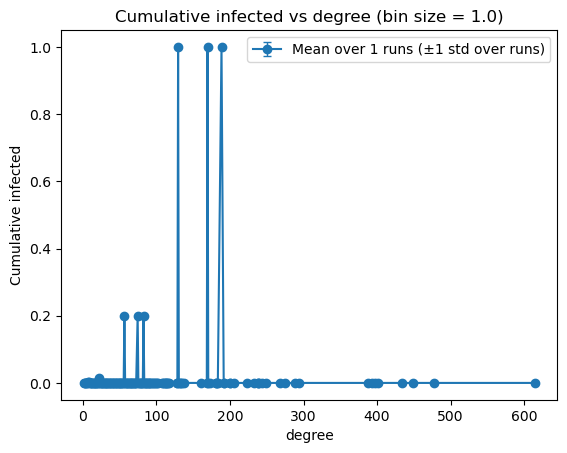

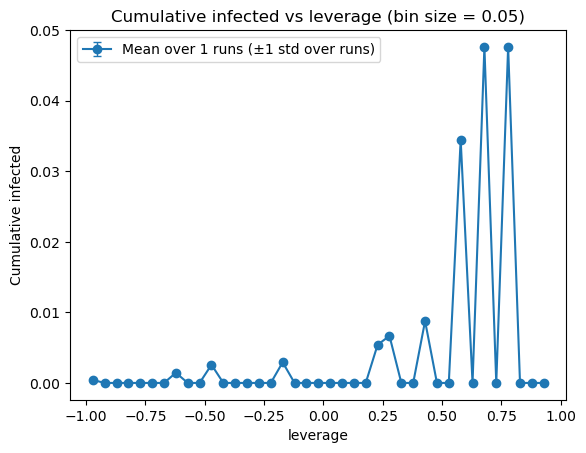

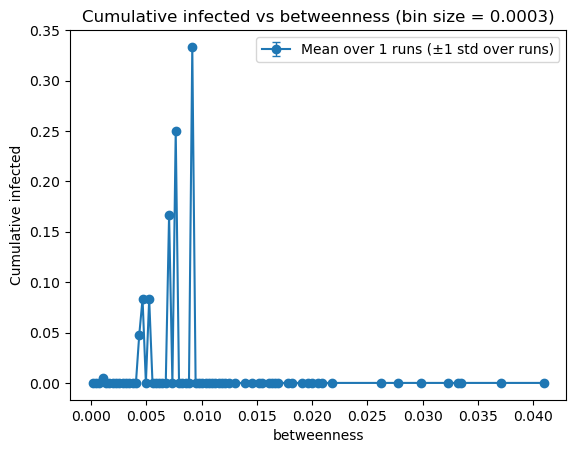

In [4]:
bin_sizes = {
    "degree": 1.0,
    "leverage": 0.05,
    "betweenness": 0.0003,
}
res = plot_cumulative_infected_vs_properties(
    n_runs=1, max_steps=1, start=1000,
    properties=["degree", "leverage", "betweenness"],
    bin_size=bin_sizes,
    use_ci=False
)
